In [4]:
import arcgis
from arcgis.gis import GIS
import pandas as pd
from arcgis import features
import os

In [2]:
env_path = "../.env"
with open(env_path) as f:
    env = {}
    for line in f:
        env_key, _val = line.split("=")
        env_value = _val.split("\n")[0]
        env[env_key] = env_value
aol_password = env['aol_key']
aol_username = env['aol_username']

In [3]:
gis = GIS("https://carcem.maps.arcgis.com/", aol_username, aol_password)

In [26]:
csv_path = "data/callejero_plano_long_table/long_table_todos.csv"

In [34]:
d = pd.read_csv(csv_path)
d.shape

(1052, 5)

In [33]:
d_para_manzanas = d[d.manzana.notnull()]
d_para_coord = d[~d.manzana.notnull()]

In [45]:
d_para_coord.columns

Index(['tipo_toponimo', 'nombre_toponimo', 'coord', 'value', 'manzana'], dtype='object')

In [37]:
d_para_coord.shape

(812, 5)

In [36]:
d_para_manzanas.shape

(240, 5)

In [38]:
d_para_manzanas_path = "data/callejero_plano_long_table/d_para_manzanas.csv"
d_para_manzanas.to_csv(d_para_manzanas_path)
csv_item = gis.content.add({}, d_para_manzanas_path)
csv_lyr = csv_item.publish(publish_parameters={'locationType':'none', 'type':'csv'})
table_lay = csv_lyr.tables[0]
manzanas_item = gis.content.get("e8133fcb8f2447808d9e9f9ad63ef238")
manzanas_flayer = manzanas_item.layers[0]

In [39]:
# identificar el coste en créditos
features.summarize_data.join_features(target_layer = manzanas_flayer, 
                                     join_layer = table_lay,
                                     attribute_relationship = [{"targetField":"Núm__de_manzana",
                                                                "operator":"equal",
                                                                "joinField":"manzana"}],
                                     join_operation = "JoinOneToMany",
                                     output_name = "toponimos_lopez_manzanas",
                                     estimate = True)

0.858

In [40]:
union_flayer_manzanas = features.summarize_data.join_features(target_layer = manzanas_flayer, 
                                     join_layer = table_lay,
                                     attribute_relationship = [{"targetField":"Núm__de_manzana",
                                                                "operator":"equal",
                                                                "joinField":"manzana"}],
                                     join_operation = "JoinOneToMany",
                                     output_name = "toponimos_lopez_manzanas",
                                     estimate = False)

{"cost": 0.858}


In [41]:
union_flayer_manzanas

<Item title:"toponimos_lopez_manzanas" type:Feature Layer Collection owner:greta_carcem>

In [42]:
d_para_coord_path = "data/callejero_plano_long_table/d_para_coord.csv"
d_para_coord.to_csv(d_para_coord_path)
csv_item = gis.content.add({}, d_para_coord_path)
csv_lyr = csv_item.publish(publish_parameters={'locationType':'none', 'type':'csv'})
table_lay = csv_lyr.tables[0]
coord_item = gis.content.get("e183b559ce94420b957b315357eb4cb7")
coord_flayer = coord_item.layers[0]

In [46]:
# identificar el coste en créditos
features.summarize_data.join_features(target_layer = coord_flayer, 
                                     join_layer = table_lay,
                                     attribute_relationship = [{"targetField":"coordenada",
                                                                "operator":"equal",
                                                                "joinField":"coord"}],
                                     join_operation = "JoinOneToMany",
                                     output_name = "toponimos_lopez_coord",
                                     estimate = True)

0.957

In [47]:
union_flayer_coord = features.summarize_data.join_features(target_layer = coord_flayer, 
                                     join_layer = table_lay,
                                     attribute_relationship = [{"targetField":"coordenada",
                                                                "operator":"equal",
                                                                "joinField":"coord"}],
                                     join_operation = "JoinOneToMany",
                                     output_name = "toponimos_lopez_coord",
                                     estimate = False)

{"cost": 0.957}


In [48]:
union_flayer_coord

<Item title:"toponimos_lopez_coord" type:Feature Layer Collection owner:greta_carcem>

## Fusión de los dos servicios

In [51]:
# identificar el coste en créditos
features.manage_data.merge_layers(input_layer=union_flayer_coord,
                      merge_layer=union_flayer_manzanas,
                      output_name="toponimos_lopez_manzanas_y_coord",
                      estimate = True)

1.09

In [52]:
fusion_lopez = features.manage_data.merge_layers(input_layer=union_flayer_coord,
                      merge_layer=union_flayer_manzanas,
                      output_name="toponimos_lopez_manzanas_y_coord",
                      estimate = False)

{"cost": 1.09}


In [55]:
fusion_lopez.id

'57c0fd7b0e9f4d59b898d63259c769e5'

# Duplicar (clonar) servicio para futura edición (incrementar la calidad)

In [56]:
hosted_flyr = gis.content.get(fusion_lopez.id)
hosted_flyr

<Item title:"toponimos_lopez_manzanas_y_coord" type:Feature Layer Collection owner:greta_carcem>

In [57]:
target = gis

In [58]:
cloned_flyr = target.content.clone_items(items=[hosted_flyr],
                                        owner="greta_carcem")

In [59]:
cloned_flyr[0].id

'7818afb150354e79b614f7eae2e66898'

<Item title:"toponimos_lopez_manzanas_y_coord_para_editar" type:Feature Layer Collection owner:greta_carcem>
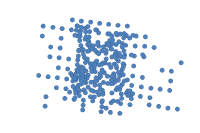

In [61]:
new_flyr = gis.content.get(cloned_flyr[0].id)
new_flyr #el nombre del item y las propiedades de edición se han cambiado via el UI de la web.